<a href="https://colab.research.google.com/github/IDL-SG1-BCI-EEG/main/blob/robin/IDL_BCI_EEG_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IDL Project: Predicting BCI_EEG signals using Deep Learning**

In [ ]:
!pip install wandb --quiet
import torch
import torchvision
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import glob
import wandb
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 1.7 MB/s eta 0:00:00


In [ ]:
# Get BCI_EEG Data 
!mkdir /content/bci_data
!wget -q https://cmu.box.com/shared/static/dje4whisfwszhe2vvfphvahzr563kp2x.zip --content-disposition --show-progress
!unzip -qo 'BCI_EEG_data.zip' -d '/content/bci_data'

"""
Original Data From:
 *https://figshare.com/articles/online_resource/Shared_data_for_exploring_training_effect_in_42_human_subjects_using_a_noninvasive_sensorimotor_rhythm-based_online_BCI/7959572*
"""

BCI_EEG_data.zip    100%[===================>]   4.84G  12.0MB/s    in 6m 54s  


'\nOriginal Data From:\n *https://figshare.com/articles/online_resource/Shared_data_for_exploring_training_effect_in_42_human_subjects_using_a_noninvasive_sensorimotor_rhythm-based_online_BCI/7959572*\n'

# **EDA**

---
...Each file includes the online results from the BCI experimentation for each run (saved in a cell variable ‘BCI_UseResults’), key parameters for the experiment (saved in a structure ‘Experiment_Parm’), key parameters for the state of the raw EEG signal (saved in a structure ‘Experimental_states’), and the raw EEG signal (saved in a variable ‘output_data’).

The raw EEG signals for experiments one and two are composed of 62 channels of EEG data with a sampling frequency of 100Hz, while data for experiment three contains 64 channels of EEG sampled at 128Hz...

In [39]:
# Loads a single .mat file into dictionary where {key=str, value=np.ndarray}
mat = scipy.io.loadmat('/content/bci_data/Exp1/Subj10_S01_Exp1.mat') 

#HIgh-Level Description of Dataset
#print(mat.keys())
#for i in mat.keys():
#    print(f'Dictionary Key: {i} (dtype: {type(i)})')
#    if isinstance(mat[i], np.ndarray):
#        print(f'Dictionary Value (dtype: {type(mat[i])}) shape: {mat[i].shape} ')
#    else: print(f'{mat[i]}')

#New variable to load formatted data
dat = dict()
dat['raw_eeg'] = mat['output_data']
 
# Reformatting 'BCI_UseResults' into a dictionary
bci_useresults = dict()
for i in mat['BCI_UseResults']:
    bci_useresults[i[1][0]] = i[0].flatten()

dat['bci_useresults'] = bci_useresults #Add formatted data to dictionary

# Reformatting 'Experiment_Parm' into a dictionary
exp_parm = dict()
for _ in mat['Experiment_Parm']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_parm[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_parm'] = exp_parm

# Reformatting 'Experimental_states' into a dictionary
exp_states = dict()
for _ in mat['Experimental_states']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_states[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_states'] = exp_states

print(f'New variable "dat" has keys: {dat.keys()}')
for key in dat.keys():
    print('--------------------------------')
    if key != 'raw_eeg':  
        print(f'Key: [{key}] contains a nested dictionary as its value:')
        for j in dat[key].keys():
            print(f'(Nested) Key: {j} ->  Input Shape: {dat[key][j].shape}')
    else: print(f'Key:[{key}] -> Input Shape:{dat[key].shape}')

New variable "dat" has keys: dict_keys(['raw_eeg', 'bci_useresults', 'exp_parm', 'exp_states'])
--------------------------------
Key:[raw_eeg] -> Input Shape:(142080, 62)
--------------------------------
Key: [bci_useresults] contains a nested dictionary as its value:
(Nested) Key: Number of trials in each run ->  Input Shape: (5,)
(Nested) Key: Number of trials hitting the targets ->  Input Shape: (5,)
(Nested) Key: Number of trials abort ->  Input Shape: (5,)
(Nested) Key: The percent valid correct for each run ->  Input Shape: (5,)
(Nested) Key: Information transfer rate for each run ->  Input Shape: (5,)
--------------------------------
Key: [exp_parm] contains a nested dictionary as its value:
(Nested) Key: PreFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: SamplingFrequency ->  Input Shape: (1,)
(Nested) Key: PostFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: ITIDuration ->  Input Shape: (1,)
(Nested) Key: Channels ->  Input Shape: (62,)
(Nested) Key: Description ->  I

targets shape: (142080,), int32
[2000 2000 2000 ... 4000 4000 4000]
125


<Axes: >

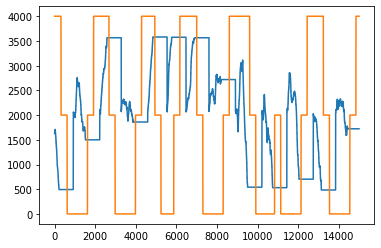

In [41]:
#Visualizing Whether Cursor Position Aligns with Target via Visualization
"""
Load TargetCode and CursorPosX variables 
TargetCode:int -> { 0 = Center; 1 = Left; 2 = Right}
"""

targets = dat['exp_states']['TargetCode']
cursor_x = dat['exp_states']['CursorPosX']

# Identify where the target changes 
#targets  is in int8, we change this just for visualization purposes
indices = np.nonzero(np.diff(targets))
targets = targets.astype(np.int32)
print(f'targets shape: {targets.shape}, {targets.dtype}')
cnt = 0
for i in indices[0]:
    if targets[i+1] > targets[i]: cnt+=1

targets[targets==2] = 4000
targets[targets==0] = 2000

print(targets)
print(cnt)
sns.lineplot(data=cursor_x[40000:55000])
sns.lineplot(data=targets[40000:55000])

In [ ]:
targets = dat['exp_states']['TargetCode']
cursor_x = dat['exp_states']['CursorPosX']

targets = targets[0][0]
targets = np.squeeze(targets)

# Maybe we can use the dict that Robin prepared to extract the targets?
# targets = exp_states['TargetCode']
# cursor = exp_states['CursorPosX']

raw_eeg = dat['raw_eeg']

# Get indices for the start/end of  each trial
trial_start_index = np.nonzero(np.diff(targets))[0][::2]+1
trial_start_end_index = np.nonzero(np.diff(targets))[0]+1

# labels to ConvNet in one data file
targets = targets[trial_start_index]
print("labels: ")
print(targets.shape)
print('-----------------------------------------------')
print("minimum trial duration: ", np.amin(np.diff(trial_start_end_index)[::2]))

raw_eeg = np.split(raw_eeg,trial_start_end_index)[1::2]
input = []

for eeg in raw_eeg:
  # index 210 to 310 (1s) because the motor imgination starts 2s after the target shows up. 210 is 2s (200) plus 0.1s (10) reaction time. 
  # The target will freeze on the screen for 1s and the shortest trial only lasts for 4.3 seconds so the upper bound needs to be <330, 4.32 (432) minus 1s (100).
  # 310 is taken to round to 100
  input.append(eeg[210:310,:])

# inputs to ConvNet in one data file
input = np.array(input)
print("input: ")
print(input.shape)

labels: 
(125,)
-----------------------------------------------
minimum trial duration:  432
input: 
(125, 100, 62)


There are total of 125 trials in each data file. The code below visualizes the first three trials with curosr position on the left and eeg signals o nthe right.

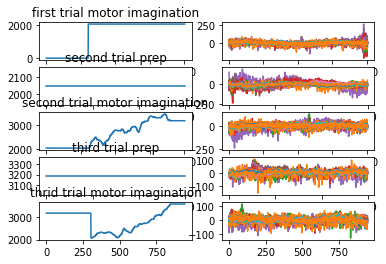

In [ ]:
# DataData Visualization
import matplotlib.pyplot as plt

cursor = mat['Experimental_states']['CursorPosX']
cursor = cursor[0][0]
cursor = np.squeeze(cursor)
raw_eeg = mat['output_data']

plt.subplot(5,2,1)
plt.plot(cursor[trial_start_end_index[0]:trial_start_end_index[1]])
plt.title("first trial motor imagination")
plt.subplot(5,2,2)
plt.plot(raw_eeg[trial_start_end_index[0]:trial_start_end_index[1],:])

plt.subplot(5,2,3)
plt.plot(cursor[trial_start_end_index[1]:trial_start_end_index[2]])
plt.title("second trial prep")
plt.subplot(5,2,4)
plt.plot(raw_eeg[trial_start_end_index[1]:trial_start_end_index[2],:])

plt.subplot(5,2,5)
plt.plot(cursor[trial_start_end_index[2]:trial_start_end_index[3]])
plt.title("second trial motor imagination")
plt.subplot(5,2,6)
plt.plot(raw_eeg[trial_start_end_index[2]:trial_start_end_index[3],:])

plt.subplot(5,2,7)
plt.plot(cursor[trial_start_end_index[3]:trial_start_end_index[4]])
plt.title("third trial prep")
plt.subplot(5,2,8)
plt.plot(raw_eeg[trial_start_end_index[3]:trial_start_end_index[4],:])

plt.subplot(5,2,9)
plt.plot(cursor[trial_start_end_index[4]:trial_start_end_index[5]])
plt.title("thrid trial motor imagination")
plt.subplot(5,2,10)
plt.plot(raw_eeg[trial_start_end_index[4]:trial_start_end_index[5],:])